In [1]:
from bs4 import BeautifulSoup as bs
import requests
import browser_cookie3
import urllib.request
import re
import pandas as pd
import sqlite3
import http.cookiejar
import sys
import numpy as np
import seaborn as sns
import html5lib
import matplotlib.pyplot as plt

In [2]:
cj = browser_cookie3.firefox(domain_name='stathead.com')

In [3]:
def ping_url(url):
    resp = requests.get(url, cookies=cj)
    return pd.read_html(resp.content)[0]

def retrieve_gamelog(year):
    url1 = 'https://stathead.com/football/player-game-finder.cgi?request=1&order_by=age_on_day&year_min='+ str(year) + '&year_max=' + str(year) +'&season_positions%5B%5D=qb&is_starter=Y&team_success_opp=win_loss_pct&win_pct_comp_opp=gt&win_pct_val_opp=.501'
    url2 = 'https://stathead.com/football/player-game-finder.cgi?request=1&order_by=age_on_day&year_min='+ str(year) + '&year_max=' + str(year) +'&season_positions%5B%5D=qb&is_starter=Y&team_success_opp=win_loss_pct&win_pct_comp_opp=gt&win_pct_val_opp=.501&offset=200'
    urls = [url1, url2]
    check_no = 1
    error_check = 0
    
    for u in urls:
        if check_no == 1:
            df1 = pd.DataFrame(ping_url(url1))
            check_no += 1
        elif check_no == 2:
            try:
                df2 = pd.DataFrame(ping_url(url2))
            except:
                error_check = 1
        else:
            return "Formula Error"
        
    if error_check == 1:
        return df1
    else:
        return pd.concat([df1, df2])[['Player','G#','Date','Team','Opp','Result']].reset_index(drop=True).sort_values(by='Player')

In [4]:
def return_years(startyear, endyear):
    df_list = []
    for y in range(startyear, endyear):
        df_list.append(retrieve_gamelog(y))
    return df_list

In [5]:
all_years = return_years(1966,2023)

In [6]:
total_gamelog = pd.concat(all_years)[['Player','G#','Date','Team','Opp','Result']].reset_index(drop=True).sort_values(by='Player')

In [7]:
total_gamelog.head(100)

,Player,G#,Date,Team,Opp,Result
8168,A.J. Feeley,11,2007-11-25,PHI,NWE,L 28-31
7496,A.J. Feeley,13,2004-12-12,MIA,DEN,L 17-20
7495,A.J. Feeley,14,2004-12-20,MIA,NWE,W 29-28
7494,A.J. Feeley,3,2004-09-26,MIA,PIT,L 3-13
7497,A.J. Feeley,12,2004-12-05,MIA,BUF,L 32-42
...,...,...,...,...,...,...
9289,Aaron Rodgers,12,2012-12-02,GNB,MIN,W 23-14
9290,Aaron Rodgers,11,2012-11-25,GNB,NYG,L 10-38
9291,Aaron Rodgers,6,2012-10-14,GNB,HOU,W 42-24
9292,Aaron Rodgers,5,2012-10-07,GNB,IND,L 27-30


In [8]:
total_gamelog['R'] = total_gamelog['Result'].apply(lambda x : x[0])

In [9]:
total_gamelog = total_gamelog[['Player', 'G#', 'Date', 'Team', 'Opp', 'R']]

In [10]:
player_stats = pd.DataFrame(columns=['Player', 'W', 'T', 'L', 'Win %'])

In [11]:
player_stats['Player'] = total_gamelog['Player'].unique()

In [12]:
player_stats[['L','W','T']] = player_stats['Player'].apply(lambda x : total_gamelog[total_gamelog['Player'] == x]['R'].value_counts())

In [13]:
player_stats[['W','T','L']] = player_stats[['W','T','L']].fillna(0)

In [14]:
player_stats['Total'] = sum([player_stats['W'], player_stats['T'], player_stats['L']])

In [15]:
player_stats['Win %'] = (player_stats['W'] + (player_stats['T']/2))/player_stats['Total']

In [16]:
player_stats['Win %'] = player_stats['Win %'].round(1)

In [17]:
player_stats[player_stats['Total'] >= 10]

,Player,W,T,L,Win %,Total
0,A.J. Feeley,2.0,0.0,8.0,0.2,10.0
2,Aaron Brooks,10.0,0.0,32.0,0.2,42.0
3,Aaron Rodgers,45.0,1.0,50.0,0.5,96.0
5,Akili Smith,1.0,0.0,10.0,0.1,11.0
6,Al Woodall,3.0,0.0,9.0,0.2,12.0
...,...,...,...,...,...,...
575,Vince Young,8.0,0.0,13.0,0.4,21.0
576,Vinny Testaverde,30.0,0.0,75.0,0.3,105.0
578,Wade Wilson,12.0,0.0,24.0,0.3,36.0
579,Warren Moon,40.0,0.0,50.0,0.4,90.0


In [18]:
pro_bowl_qbs = pd.DataFrame(ping_url('https://stathead.com/football/player-season-finder.cgi?request=1&match=player_season_combined&order_by=age&positions%5B%5D=qb&pro_bowls_type=Y'))

In [19]:
pro_bowl_qbs = pro_bowl_qbs[['Player', 'PB']]

In [20]:
pro_bowl_qbs

,Player,PB
0,Matt Hasselbeck,3
1,Peyton Manning,14
2,Dan Fouts,6
3,Bill Kenney,1
4,Tommy Kramer,1
...,...,...
173,Alex Smith,3
174,Matthew Stafford,2
175,Fran Tarkenton,9
176,Michael Vick,4


In [21]:
all_pro_qbs = pd.DataFrame(ping_url('https://stathead.com/football/player-season-finder.cgi?request=1&match=player_season_combined&order_by=age&year_min=1966&positions%5B%5D=qb&all_pros_first_team_type=Y'))[['Player', 'AP1']]

In [22]:
all_pro_qbs

,Player,AP1
0,Aaron Rodgers,4
1,Steve Young,3
2,Randall Cunningham,1
3,Johnny Unitas,1
4,Earl Morrall,2
5,Bart Starr,1
6,John Brodie,1
7,Len Dawson,1
8,Brett Favre,3
9,Kurt Warner,2


In [23]:
hof_qbs = pd.DataFrame(ping_url('https://stathead.com/football/player-season-finder.cgi?request=1&match=player_season_combined&order_by=age&positions%5B%5D=qb&is_hof=Y'))

In [24]:
hof_qbs['HoF'] = 'Y'

In [25]:
hof_qbs = hof_qbs[['Player', 'HoF']]

In [26]:
hof_qbs

,Player,HoF
0,Sammy Baugh,Y
1,Charley Trippi,Y
2,Warren Moon,Y
3,Roger Staubach,Y
4,Kurt Warner,Y
5,Jim Kelly,Y
6,Paddy Driscoll,Y
7,Otto Graham,Y
8,Ken Stabler,Y
9,Bob Waterfield,Y


In [27]:
player_stats_nu = pd.read_csv('numbers.csv')[['Player', 'W', 'T', 'L', 'Win %', 'Total']]

In [28]:
player_stats_nu

,Player,W,T,L,Win %,Total
0,A.J. Feeley,2.0,0.0,8.0,0.200000,10.0
1,A.J. McCarron,0.0,0.0,2.0,0.000000,2.0
2,Aaron Brooks,10.0,0.0,32.0,0.238095,42.0
3,Aaron Rodgers,46.0,1.0,50.0,0.479381,97.0
4,Adrian Breen,0.0,0.0,1.0,0.000000,1.0
...,...,...,...,...,...,...
596,Will Levis,1.0,0.0,6.0,0.142857,7.0
597,Willie Totten,0.0,0.0,1.0,0.000000,1.0
598,Zach Mettenberger,0.0,0.0,7.0,0.000000,7.0
599,Zach Wilson,6.0,0.0,13.0,0.315789,19.0


In [29]:
player_stats_nu = player_stats_nu.merge(pro_bowl_qbs, left_on='Player', right_on='Player', how='left')
player_stats_nu = player_stats_nu.merge(all_pro_qbs, left_on='Player', right_on='Player', how='left')
player_stats_nu = player_stats_nu.merge(hof_qbs, left_on='Player', right_on='Player', how='left')

In [30]:
player_stats_nu[['HoF']] = player_stats_nu[['HoF']].fillna('N')
player_stats_nu[['PB', 'AP1']] = player_stats_nu[['PB', 'AP1']].fillna(0)

In [31]:
player_stats_nu.to_csv('numbers2.csv')

In [32]:
player_stats_nu

,Player,W,T,L,Win %,Total,PB,AP1,HoF
0,A.J. Feeley,2.0,0.0,8.0,0.200000,10.0,0.0,0.0,N
1,A.J. McCarron,0.0,0.0,2.0,0.000000,2.0,0.0,0.0,N
2,Aaron Brooks,10.0,0.0,32.0,0.238095,42.0,0.0,0.0,N
3,Aaron Rodgers,46.0,1.0,50.0,0.479381,97.0,10.0,4.0,N
4,Adrian Breen,0.0,0.0,1.0,0.000000,1.0,0.0,0.0,N
...,...,...,...,...,...,...,...,...,...
596,Will Levis,1.0,0.0,6.0,0.142857,7.0,0.0,0.0,N
597,Willie Totten,0.0,0.0,1.0,0.000000,1.0,0.0,0.0,N
598,Zach Mettenberger,0.0,0.0,7.0,0.000000,7.0,0.0,0.0,N
599,Zach Wilson,6.0,0.0,13.0,0.315789,19.0,0.0,0.0,N


In [33]:
player_stats_nu[player_stats_nu['Total'] > 9]

,Player,W,T,L,Win %,Total,PB,AP1,HoF
0,A.J. Feeley,2.0,0.0,8.0,0.200000,10.0,0.0,0.0,N
2,Aaron Brooks,10.0,0.0,32.0,0.238095,42.0,0.0,0.0,N
3,Aaron Rodgers,46.0,1.0,50.0,0.479381,97.0,10.0,4.0,N
6,Akili Smith,1.0,0.0,10.0,0.090909,11.0,0.0,0.0,N
7,Al Woodall,3.0,0.0,9.0,0.250000,12.0,0.0,0.0,N
...,...,...,...,...,...,...,...,...,...
588,Vince Young,8.0,0.0,13.0,0.380952,21.0,2.0,0.0,N
589,Vinny Testaverde,30.0,0.0,75.0,0.285714,105.0,2.0,0.0,N
591,Wade Wilson,12.0,0.0,24.0,0.333333,36.0,1.0,0.0,N
592,Warren Moon,40.0,0.0,50.0,0.444444,90.0,9.0,0.0,Y


In [34]:
def assign_status(row):
    if row['HoF'] == 'Y':
        return 'HoF'
    elif row['AP1'] > 0:
        return 'All Pro'
    elif row['PB'] > 0:
        return 'Pro Bowler'
    else:
        return 'JAG'    

In [35]:
player_stats_nu['Status'] = player_stats_nu.apply(assign_status, axis=1)

In [36]:
player_stats_nu[(player_stats_nu['Status'] != 'JAG') * (player_stats_nu['Total'] > 9)].sort_values(by='Win %', ascending=False)

,Player,W,T,L,Win %,Total,PB,AP1,HoF,Status
73,Brock Purdy,9.0,0.0,3.0,0.750000,12.0,1.0,0.0,N,Pro Bowler
299,Joe Montana,43.0,0.0,21.0,0.671875,64.0,8.0,3.0,Y,HoF
177,Don Meredith,7.0,1.0,4.0,0.625000,12.0,3.0,0.0,N,Pro Bowler
249,Jalen Hurts,15.0,0.0,9.0,0.625000,24.0,2.0,0.0,N,Pro Bowler
434,Patrick Mahomes,25.0,0.0,16.0,0.609756,41.0,6.0,2.0,N,All Pro
...,...,...,...,...,...,...,...,...,...,...
263,Jeff Blake,8.0,0.0,36.0,0.181818,44.0,1.0,0.0,N,Pro Bowler
399,Matthew Stafford,16.0,0.0,80.0,0.166667,96.0,2.0,0.0,N,Pro Bowler
238,Jack Kemp,2.0,1.0,13.0,0.156250,16.0,7.0,0.0,N,Pro Bowler
166,Derek Anderson,2.0,0.0,18.0,0.100000,20.0,1.0,0.0,N,Pro Bowler


In [37]:
player_stats_nu[(player_stats_nu['AP1'] == 0) * (player_stats_nu['HoF'] == 'Y')]

,Player,W,T,L,Win %,Total,PB,AP1,HoF,Status
220,George Blanda,1.0,0.0,2.0,0.333333,3.0,4.0,0.0,Y,HoF
308,John Elway,46.0,0.0,53.0,0.464646,99.0,9.0,0.0,Y,HoF
464,Roger Staubach,26.0,0.0,21.0,0.553191,47.0,6.0,0.0,Y,HoF
504,Sonny Jurgensen,11.0,1.0,28.0,0.287500,40.0,5.0,0.0,Y,HoF
575,Troy Aikman,30.0,0.0,45.0,0.400000,75.0,6.0,0.0,Y,HoF
592,Warren Moon,40.0,0.0,50.0,0.444444,90.0,9.0,0.0,Y,HoF


<AxesSubplot:xlabel='Win %', ylabel='Count'>

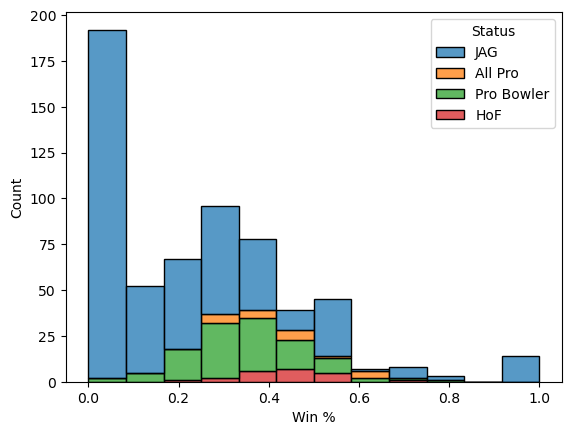

In [38]:
sns.histplot(data=player_stats_nu, x='Win %', hue='Status', multiple='stack')

<AxesSubplot:xlabel='Win %', ylabel='Count'>

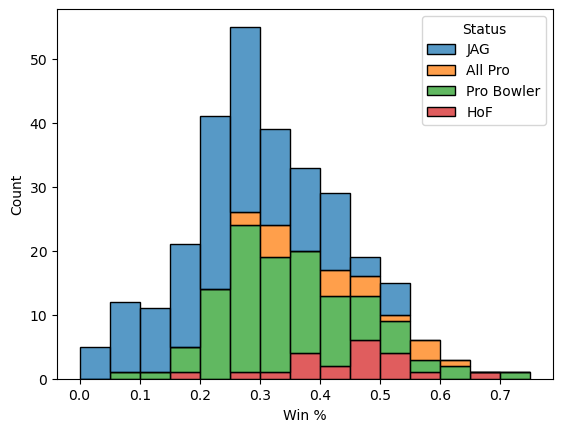

In [39]:
sns.histplot(data=player_stats_nu[player_stats_nu['Total'] > 9], x='Win %', hue='Status', multiple='stack')